In [221]:
import pandas as pd
import numpy as np
import sklearn as sk
import pickle
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# load data
data is generated from another script with feature engineering

In [222]:
df = pd.read_csv('../tmp/processed_df_2017.csv', parse_dates=['transactiondate'])

In [223]:
# load feature names
feats_numeric = pickle.load(open('../tmp/feats_numeric.pkl', 'r'))
feats_categorical = pickle.load(open('../tmp/feats_categorical.pkl', 'r'))
feats = pickle.load(open('../tmp/feats.pkl', 'r'))

In [224]:
# load train/validation/prediction labels

In [225]:
mask_train = pickle.load(open('../tmp/mask_train.pkl', 'r'))
mask_test = pickle.load(open('../tmp/mask_validation.pkl', 'r'))
mask_prediction = pickle.load(open('../tmp/mask_prediction.pkl', 'r'))

# Impute missing values

In [226]:
# need to impute all these with a `missing` value first
df[feats_categorical] = df[feats_categorical].fillna('--unknown--')

In [227]:
# use label encoder to encode all categorical variables
le = LabelEncoder()
for feat in feats_categorical:
    df[[feat]] = df[[feat]].apply(le.fit_transform)

In [228]:
imp =  Imputer(missing_values=np.nan, strategy="median", axis=0)
# df[feats_numeric] = imp.fit_transform(df[feats_numeric])
for feat in feats_numeric:
    if df[feat].isnull().sum() < df.shape[0]:
        df[[feat]] = imp.fit_transform(df[[feat]])
    else:
        df[feat] = 0

# generate training testing sets

In [229]:
# some extra filtering to remove outliers
# X_train = df.loc[mask_train, feats].astype(float).values
# X_test = df.loc[mask_test, feats].astype(float).values

X_train = df.loc[(mask_train & (df.logerror<=0.419) & (df.logerror>=-0.4)), feats].astype(float).values
X_test = df.loc[mask_test, feats].astype(float).values

y_train = np.array(df.loc[(mask_train & (df.logerror<=0.419) & (df.logerror>=-0.4)), 'logerror'].tolist())
y_test = np.array(df.loc[mask_test, 'logerror'].tolist())

X_pred = df.loc[mask_prediction, feats].astype(float).values

# Train models

In [230]:
np.random.seed(42)
random.seed(42)

## 1. LightGBM

In [231]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'          # or 'mae'
params['sub_feature'] = 0.345    
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [232]:
d_train = lgb.Dataset(X_train, label=y_train)

In [233]:
# fit model
fit = lgb.train(params, d_train, 430)

In [234]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test)
pred_lgb = fit.predict(X_pred)

In [235]:
def report_test_set_performance():
    #explained_variance_score(y_pred=y_pred, y_true=y_test)
    print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))
    # pd.Series(pred_lgb_test).hist()

In [236]:
report_test_set_performance()

MAE:0.073243


In [237]:
# when not using october's data
report_test_set_performance()

MAE:0.073243


## 2.Xgboost

In [238]:
# xgboost params
params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train),
    'silent': 1
}

In [239]:
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test)
d_pred = xgb.DMatrix(X_pred)

In [240]:
num_boost_rounds = 150
fit = xgb.train(dict(params, silent=1), d_train, num_boost_round=num_boost_rounds)

In [241]:
# prediction for test set and prediction set
y_pred = fit.predict(d_test)
pred_xgb = fit.predict(d_pred)

In [242]:
report_test_set_performance()

MAE:0.076796


In [243]:
# when not using oct data
report_test_set_performance()

MAE:0.076796


## 3. Random Forest

In [244]:
params = {
    "max_depth": 10,
    "min_samples_split": 50,
    "n_estimators": 200
}

In [245]:
fit = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1, **params)
fit.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=42, verbose=1, warm_start=False)

In [246]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test)
pred_rf = fit.predict(X_pred)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   14.9s finished


In [247]:
report_test_set_performance()

MAE:0.076814


In [248]:
report_test_set_performance()

MAE:0.076814


## 4. Elastic Net

In [249]:
params = {
    'l1_ratio':0.7, 
}

In [250]:
fit = ElasticNet(**params)
fit.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [251]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test)
pred_enet = fit.predict(X_pred)

In [252]:
report_test_set_performance()

MAE:0.073539


In [253]:
report_test_set_performance()

MAE:0.073539


# Ensenmble - bagging

In [254]:
model_weights = {
    'light_gbm': 1,
    'xgboost': 0.00,
    'random_forest': 0.00,
    'elastic_net': 0.1,
    'baseline': 0.001,
}

In [255]:
pred_all = \
    (pred_lgb * model_weights['light_gbm'] + \
    pred_xgb * model_weights['xgboost'] +\
    pred_rf * model_weights['random_forest'] +\
    pred_enet * model_weights['elastic_net'] +\
    df.logerror.mean() * model_weights['baseline']) / sum(model_weights.values())

# generate submission file

In [256]:
df_submission = df[['parcelid','logerror']]
df_submission['pred'] = pred_all

In [257]:
# df_submission['201610'] = df_submission['logerror'].combine_first(df_submission['pred'])
df_submission['201610'] = df_submission['pred']
df_submission['201611'] = df_submission['pred']
df_submission['201612'] = df_submission['pred']
df_submission['201710'] = df_submission['pred']
df_submission['201711'] = df_submission['pred']
df_submission['201712'] = df_submission['pred']

In [258]:
df_submission.drop_duplicates(subset = ['parcelid'], keep='first', inplace = True)

In [259]:
del df_submission['logerror']
del df_submission['pred']

In [260]:
df_submission.shape[0] == 2985217

True

In [261]:
df_submission.to_csv('../tmp/submission_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [262]:
# I want to quickly explore the logerror's trend over time

In [304]:
t = df[['transactiondate', 'logerror']]
t = t[~t.logerror.isnull()]
t = t[t.transactiondate < '2017']

In [305]:
t['abs_logerror'] = abs(t.logerror)

In [306]:
t.set_index(pd.to_datetime(t.transactiondate), inplace = True)

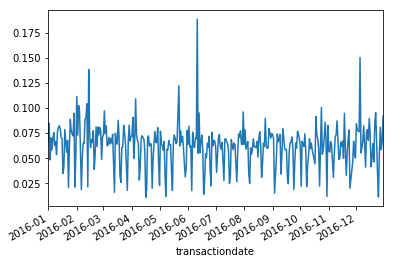

In [307]:
t.groupby('transactiondate').aggregate('mean')['abs_logerror'].plot()

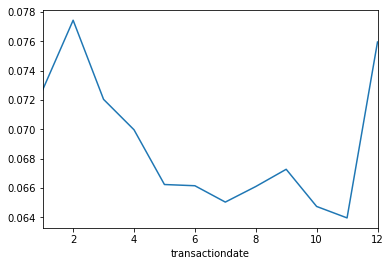

In [308]:
# 2016
t.groupby(by=[t.index.month]).aggregate('mean')['abs_logerror'].plot()

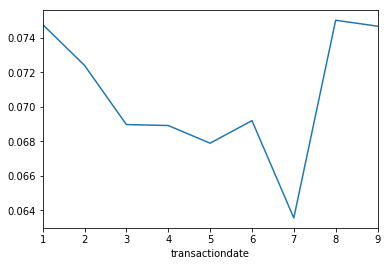

In [302]:
# 2017
t.groupby(by=[t.index.month]).aggregate('mean')['abs_logerror'].plot()